In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# The Kaggle Competition: https://www.kaggle.com/competitions/optiver-trading-at-the-close/overview

## Other code for inspiration:
# https://www.kaggle.com/competitions/optiver-trading-at-the-close/code?competitionId=57891&sortBy=voteCount&language=Python&excludeNonAccessedDatasources=true
# https://www.kaggle.com/competitions/optiver-trading-at-the-close/leaderboard

### Optiver Training Data

This dataset contains historic data for the daily ten minute closing auction on the NASDAQ stock exchange. Your challenge is to predict the future price movements of stocks relative to the price future price movement of a synthetic index composed of NASDAQ-listed stocks.

Goal: Merge traditional order book trading with price auction data

Note:
- All size related columns are in USD terms.
- All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.

#### Note: this is actually our testing data too, because we only have the entire Optiver training data from the Kaggle competition

One issue is that we use mean values of the entire dataframe to fill in nan values
We also use the median values of the stock's typical volume over all of the data

However, this shouldn't make too much of a difference, so don't worry about it for now

WHEN THE SPLIT HAPPENS THOUGH, IT SHOULD BE BETWEEN DATES

### Describing Closing Auction

In a closing auction, orders are collected over a pre-determined timeframe and then matched at a single price determined by the buy & sell demand expressed by auction participants. For Nasdaq Closing auctions, the exchange begins accepting orders at the start of the trading day and begins publishing the state of the auction book at 3:50pm ET for 10 minutes before the market closes at 4pm ET, at which point the orders are matched instantly at a single price.

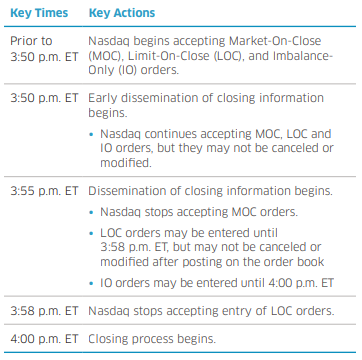

The closing price is determined as: The price at which the maximum number of shares can be matched.

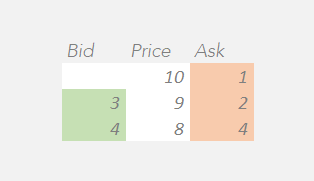

The book in the example below is referred to as in cross, since the best bid and ask are overlapping. The closing auction price is therefore referred to as the uncross price, the price at which the shares which were in cross are matched.

    At a price of 10, 0 lots would be matched since there as no bids >= 10.
    At a price of 9, 3 lots would be matched, as there are 3 bids >=9 and 6 asks <= 9.
    At a price of 8, 4 lots would be matched, since are 7 bids>=8, and there are 4 asks<=8.

So the price which maximises the number of matched lots would be 8. We would therefore describe the auction order book in the following way:

    The uncross price is 8
    The matched size would be 4
    The imbalance would be 3 lots in the buy direction

The term **far price** refers to the hypothetical uncross price of the auction book, if it were to uncross at the reporting time. Nasdaq provides far price information 5 minutes before the closing cross. This is why we have a lot of NaN values for column "far_price" in the below df

### Describing Order Book

The term order book refers to an electronic list of buy (also known as bid) and sell (also known as ask) orders for a specific security or financial instrument organized by price level.

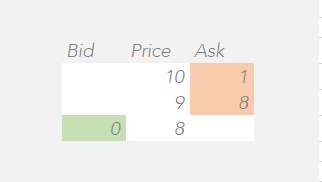

### Combining book

Combining the two books can result in a more accurate reflection of the market's buying and selling interest at different price levels. This aids in better price discovery, allowing the market to reach a more accurate and fair equilibrium price when the auction uncrosses.

For the combined book, the hypothetical cross size is called **near price**. Because Nasdaq does not release full auction information until 5 minutes before the closing cross, we have a lot of NaN values for the column "near_price" in the below df.

Nasdaq does however provide an indication of the fair price caled the **reference price**. Its calculation comes as follows:

    If the near price is between the best bid and ask, then the reference price is equal to the near price
    If the near price > best ask, then reference price = best ask
    If the near price < best bid, then reference price = best bid 
    So the reference price is the near price bounded between the best bid and ask.

In [45]:
## How to read the training data now
file_path = "optiver_training_data/train_part_1.csv.zip"
df_1 = pd.read_csv(file_path, compression='zip')

file_path = "optiver_training_data/train_part_2.csv.zip"
df_2 = pd.read_csv(file_path, compression='zip')

file_path = "optiver_training_data/train_part_3.csv.zip"
df_3 = pd.read_csv(file_path, compression='zip')

df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [46]:
df.shape

(5237980, 17)

In [47]:
df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [49]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


What the columns mean:

1. **stock_id**: A unique identifier for the stock. Not all stock IDs exist in every time bucket.
2. **date_id**: A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
3. **imbalance_size**: The amount unmatched at the current reference price (in USD). This is for the closing auction.
4. **imbalance_buy_sell_flag**: An indicator reflecting the direction of auction imbalance.
buy-side imbalance; 1
sell-side imbalance; -1
no imbalance; 0
5. **reference_price**: Indication of the fair price. Equal to the near price (look below) bounded between the best bid and ask price in order book.
6. **matched_size**: The amount that can be matched at the current reference price (in USD). This is for the closing auction.
7. **far_price**: The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders. Only available after 300 seconds.
8. **near_price**: The crossing price that will maximize the number of shares matched based auction and continuous market orders. Only available after 300 seconds.
9. **[bid/ask]_price**: Price of the most competitive buy/sell level in the non-auction book.
10. **[bid/ask]_size**: The dollar notional amount on the most competitive buy/sell level in the non-auction book.
11. **wap**: The weighted average price in the non-auction book $\frac{BidPrice*AskSize + AskPrice*BidSize}{BidSize + AskSize}$
 12. **seconds_in_bucket**: The number of seconds elapsed since the beginning of the day's closing auction, always starting from $0$. Will go from $0$ to $540$, i.e. up to minute 9 of 10 minute action
13. **target**: The $60$ second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
    
        i) The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.

        ii) The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.

        iii) Where t is the time at the current observation, we can define the target

    $Target = \left( \frac{StockWap_{t+60}}{StockWap_{t}} - \frac{IndexWAP_{t+60}}{IndexWAP_{t}} \right) * 10000$

In [50]:
number_stocks = df["stock_id"].nunique()
number_dates = df["date_id"].nunique()
number_times = df["time_id"].nunique()
number_seconds = df["seconds_in_bucket"].nunique()

min_sec = df["seconds_in_bucket"].min()
max_sec = df["seconds_in_bucket"].max()


print((f"The primary keys for the df (columns that uniquely identify a row) are the 'stock_id', "
        f"'date_id', and 'time_id'. There are total of {number_stocks} differnt stocks, {number_dates} days of"
        f"days of data, and {number_times} unqiue times during end of closing day (up to minute 9). "
        f"The timing in this auction bucket goes from second {min_sec} (or minute {int(min_sec/60)}) to {max_sec} (or minute {int(max_sec/60)})"
))

print(f"Note though, we can also uniquely identify a row by replacing 'time_id' with 'seconds_in_bucket', which only has {number_seconds} unique values")

The primary keys for the df (columns that uniquely identify a row) are the 'stock_id', 'date_id', and 'time_id'. There are total of 200 differnt stocks, 481 days ofdays of data, and 26455 unqiue times during end of closing day (up to minute 9). The timing in this auction bucket goes from second 0 (or minute 0) to 540 (or minute 9)
Note though, we can also uniquely identify a row by replacing 'time_id' with 'seconds_in_bucket', which only has 55 unique values


In [51]:
df["seconds_in_bucket"].unique()

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
       520, 530, 540])

In [52]:
data_per_day = int(df.groupby(['stock_id', 'date_id']).size().reset_index(name='count')["count"].mean())
print(f"Each stock at the end of closing day, if the data is avilable, has {data_per_day} data points, 1 for each time bucket")

Each stock at the end of closing day, if the data is avilable, has 55 data points, 1 for each time bucket


In [53]:
# Note: There are some weird phenomenon due to time data aspect of project (Part 1)

# While the reference price is supposed to be bounded by the best bid and ask in order book, there are outliers likely due to data
# recording issues; otherwise, we'd expect this to have no rows
df[(df["reference_price"] > df["ask_price"]) | (df["reference_price"] < df["bid_price"])]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.000000,7.970333,0,0_0_9
10,10,0,0,10482752.19,-1,1.001374,8839457.10,NaN,NaN,0.999885,18802.00,1.001321,217098.37,1.000000,5.350113,0,0_0_10
13,13,0,0,5749286.01,1,0.998995,7039173.61,NaN,NaN,0.999074,12327.73,1.000096,1272.20,1.000000,-10.750294,0,0_0_13
17,17,0,0,12411362.37,-1,1.000966,27288881.25,NaN,NaN,0.999028,12438.00,1.000648,8305.44,1.000000,-3.589988,0,0_0_17
22,22,0,0,5053387.79,1,0.999537,6722747.70,NaN,NaN,0.999767,9467.74,1.000458,18644.34,1.000000,8.959770,0,0_0_22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237623,43,480,530,0.00,0,0.998432,13853987.69,0.998432,0.998432,0.998491,16673.00,0.998731,33354.00,0.998571,-1.339912,26453,480_530_43
5237729,149,480,530,6190032.00,1,1.001809,86142825.64,1.002784,1.002651,1.001587,22600.00,1.001765,45886.12,1.001646,3.969669,26453,480_530_149
5237747,167,480,530,197293.66,1,1.000204,12479013.42,1.000204,1.000204,0.999676,16088.80,0.999887,94.66,0.999886,-0.380278,26453,480_530_167
5237876,96,480,540,0.00,0,0.994122,66018285.00,0.994122,0.994122,0.994288,1675.52,0.994454,188766.90,0.994289,-3.780127,26454,480_540_96


In [54]:
# Note: There are some weird phenomenon due to time data aspect of project (Part 2)

# Again, we would expect that the reference price = near price, when the near price is within bounds of the order book bid/ask
# However, there are some outliers, but again we are dealing with time data, so this is somewhat expected
# Note we only get near price after 300 seconds in the bucket (5 minutes)
df[(df["near_price"] <= df["ask_price"]) & (df["near_price"] >= df["bid_price"]) & (df["near_price"] != df["reference_price"])][["near_price", "reference_price", "seconds_in_bucket"]]

,near_price,reference_price,seconds_in_bucket
5894,0.998103,0.999210,300
5905,0.999924,1.000269,300
5910,1.000163,1.000066,300
6004,1.011024,1.010495,310
6034,0.999578,0.998949,310
...,...,...,...
5237922,0.997257,0.997095,540
5237926,1.001328,1.001121,540
5237953,1.000614,1.000665,540
5237957,0.997944,0.998270,540


In [55]:
# These values don't begin until second 300
df[df['far_price'].notna()]["seconds_in_bucket"].min()

300

In [56]:
# These values don't begin until second 300
df[df['near_price'].notna()]["seconds_in_bucket"].min()

300

In [57]:
# Deal with Nan columns
# Makes sense now that we only have NaN's for far_price and near_price, which don't get released until later on in last 10 minutes
df = df.dropna(subset=["wap"])
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                   0
imbalance_buy_sell_flag          0
reference_price                  0
matched_size                     0
far_price                  2894122
near_price                 2856960
bid_price                        0
bid_size                         0
ask_price                        0
ask_size                         0
wap                              0
target                           0
time_id                          0
row_id                           0
dtype: int64

In [58]:
# Fill in nan values (can decide to go different route in the future)
na_columns = ["far_price", "near_price"]
for column in na_columns:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

df.isna().sum().sum()

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_98596/3075278074.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mean_value, inplace=True)


0

#### Understanding how price movements adjust over time (Example)


In [59]:
df_example = df[(df["stock_id"] == 0) & (df["date_id"] == 0)] # Arbitrary choice just for viewing

df_example["imbalance_size (+ direction)"] = df['imbalance_size'] * df['imbalance_buy_sell_flag']
x_col = "seconds_in_bucket"
y_cols_1 =["imbalance_size (+ direction)", 'matched_size']
y_cols_2 = ['bid_price', 'ask_price', 'wap']
y_cols_3 = ['reference_price', 'far_price', 'near_price']
title_1 = 'Stock 0 on Day 0 - How the auction sizing changes during the auction period'
title_2 = "title='Stock 0 on Day 0 - How the order book pricing changes during the auction"
title_3 = 'Stock 0 on Day 0 - How the auction & combined book pricing changes during the auction'
target_col = "target"    

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_98596/2996533213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example["imbalance_size (+ direction)"] = df['imbalance_size'] * df['imbalance_buy_sell_flag']


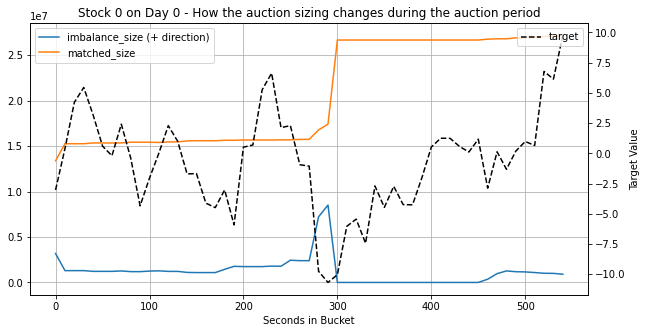

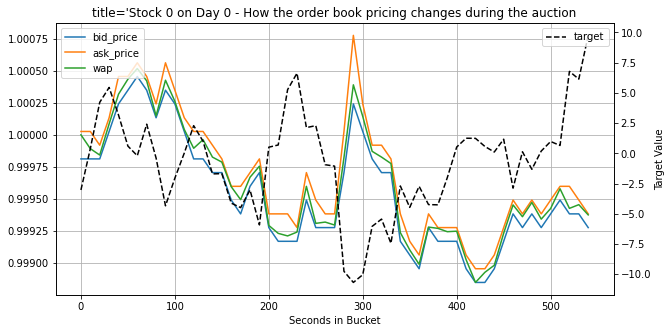

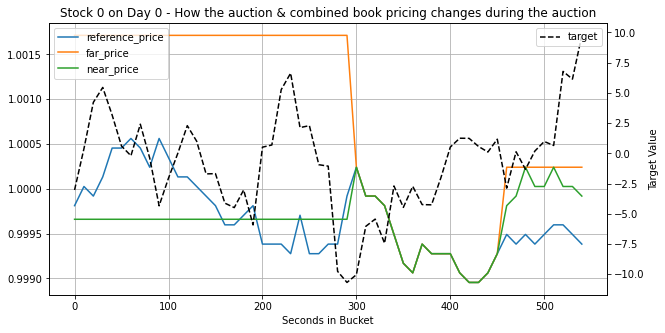

In [60]:
# Function to plot with secondary y-axis for 'target'
def plot_with_target(x, y_cols, title):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Primary y-axis
    for col in y_cols:
        ax1.plot(df_example[x], df_example[col], label=col)
    ax1.set_xlabel("Seconds in Bucket")
    ax1.set_title(title)
    ax1.legend(loc="upper left")
    ax1.grid()

    # Secondary y-axis for target values
    ax2 = ax1.twinx()
    ax2.plot(df_example[x], df_example[target_col], color='black', linestyle='dashed', label=target_col)
    ax2.set_ylabel("Target Value")
    ax2.legend(loc="upper right")

    plt.show()

plot_with_target(x_col, y_cols_1, title_1)
plot_with_target(x_col, y_cols_2, title_2)
plot_with_target(x_col, y_cols_3, title_3)

### How to test how well our model does?

Look at baseline and simple strategy that we should beat

In [61]:
# Baseline prediction
df['baseline_prediction'] = 0
baseline_mae = (df['baseline_prediction'] - df['target']).abs().mean()

In [62]:
# Simple Strategy 1
simple_mapping = {
    1: 0.1,
    0: 0,
    -1: -0.1
}
df['simple_prediction'] = df['imbalance_buy_sell_flag'].map(simple_mapping)
simple_prediction_mae = (df['simple_prediction'] - df['target']).abs().mean()


In [63]:
# Comparison of results
print(baseline_mae, simple_prediction_mae)
print('MAE improvement in basis points: ', (baseline_mae-simple_prediction_mae))

6.4077673733353055 6.407053280199083
MAE improvement in basis points:  0.0007140931362226155


## Finally: Creating Some Relevant Features

The features should make some sense intuitively, for why they can be predict our target

In [64]:
## Just for reference to have while doing this
df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'baseline_prediction',
       'simple_prediction'],
      dtype='object')

In [65]:
# Groups the 'seconds_in_bucket' column into three categories:
# This is based on how Nasdaq timeline works (new rules/results at minute 5 and 8)

# 0 → If seconds_in_bucket is less than 300
# 1 → If seconds_in_bucket is between 300 and 479
# 2 → If seconds_in_bucket is 480 or more

df["seconds_in_bucket_group"] = pd.cut(
    df["seconds_in_bucket"],
    bins=[-np.inf, 300, 480, np.inf],  # Define bin edges
    labels=[0, 1, 2]                    # Assign categories
).astype(np.float32)
df["seconds_in_bucket_group"]

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
5237975    2.0
5237976    2.0
5237977    2.0
5237978    2.0
5237979    2.0
Name: seconds_in_bucket_group, Length: 5237760, dtype: float32

In [66]:
## Make the base features we want

# handle the Nan values though in the meantime

In [67]:
median_vol = df.groupby('stock_id')['bid_size'].median() + df.groupby('stock_id')['ask_size'].median()

df['imbalance_buy_flag'] = np.where(df['imbalance_buy_sell_flag']==1, 1, 0) 
df['imbalance_sell_flag'] = np.where(df['imbalance_buy_sell_flag']==-1, 1, 0) 
df['no_imbalance'] = np.where(df['imbalance_buy_sell_flag']==0, 1, 0) 
df['bid_plus_ask_sizes'] = df['bid_size'] + df['ask_size']
df['median_vol'] = df['stock_id'].map(median_vol.to_dict())
df['high_volume'] = np.where(df['bid_plus_ask_sizes'] > df['median_vol'], 1, 0) 
df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
df['bid_ask_volume_diff'] = df['ask_size'] - df['bid_size']
df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2
df['bid_plus_ask_sizes'] = df['bid_size'] + df['ask_size']
df["size_imbalance"] = df.eval("bid_size / ask_size")


In [68]:
df["price_spread"] = df["ask_price"] - df["bid_price"]
df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
df['matched_imbalance'] = df.eval('(imbalance_size - matched_size) / (matched_size + imbalance_size)').astype(np.float32)

df["market_urgency"] = df["price_spread"] * df["liquidity_imbalance"]
df["market_urgency_v2"] = (df["ask_price"]+df["bid_price"])/2 - (df["bid_price"]*df["bid_size"]+df["ask_price"]*df["ask_size"]) / (df["bid_size"]+df["ask_size"])

In [69]:
# generate imbalance features (store their names in this list)
new_features = []

# Define price levels for calculations
prices = ['reference_price', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wap']

# Pairwise price imbalance features
for i, a in enumerate(prices):
    for j, b in enumerate(prices):
        if i > j:
            feature_name = f'{a}_{b}_imb'
            df[feature_name] = (df[a] - df[b]) / (df[a] + df[b])
            new_features.append(feature_name)

# Triple-price imbalance features
for i, a in enumerate(prices):
    for j, b in enumerate(prices):
        for k, c in enumerate(prices):
            if i > j and j > k:
                max_ = df[[a, b, c]].max(axis=1)
                min_ = df[[a, b, c]].min(axis=1)
                mid_ = df[[a, b, c]].sum(axis=1) - min_ - max_

                feature_name = f'{a}_{b}_{c}_imb2'
                df[feature_name] = ((max_ - mid_) / (mid_ - min_)).astype(np.float32)
                new_features.append(feature_name)
new_features


['far_price_reference_price_imb',
 'near_price_reference_price_imb',
 'near_price_far_price_imb',
 'bid_price_reference_price_imb',
 'bid_price_far_price_imb',
 'bid_price_near_price_imb',
 'ask_price_reference_price_imb',
 'ask_price_far_price_imb',
 'ask_price_near_price_imb',
 'ask_price_bid_price_imb',
 'wap_reference_price_imb',
 'wap_far_price_imb',
 'wap_near_price_imb',
 'wap_bid_price_imb',
 'wap_ask_price_imb',
 'near_price_far_price_reference_price_imb2',
 'bid_price_far_price_reference_price_imb2',
 'bid_price_near_price_reference_price_imb2',
 'bid_price_near_price_far_price_imb2',
 'ask_price_far_price_reference_price_imb2',
 'ask_price_near_price_reference_price_imb2',
 'ask_price_near_price_far_price_imb2',
 'ask_price_bid_price_reference_price_imb2',
 'ask_price_bid_price_far_price_imb2',
 'ask_price_bid_price_near_price_imb2',
 'wap_far_price_reference_price_imb2',
 'wap_near_price_reference_price_imb2',
 'wap_near_price_far_price_imb2',
 'wap_bid_price_reference_pric

In [70]:
# How much each stock is of importance in the index
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}
# the weights of the synthetic index can be rebuilt by applying linear regression on the stock & index return
# https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/442851

df["stock_weights"] = df["stock_id"].map(weights)
df["weighted_wap"] = df["stock_weights"] * df["wap"]
df['wap_momentum'] = df.groupby(['stock_id', 'date_id'])['weighted_wap'].pct_change(periods=6)

In [71]:
df["imbalance_momentum"] = df.groupby(['stock_id', 'date_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
df["spread_intensity"] = df.groupby(['stock_id', 'date_id'])['price_spread'].diff()
df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])

df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
df['mid_price_movement'] = (
    df.groupby('stock_id')['mid_price']
    .diff(periods=5)
    .apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
)

df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']

prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

# done each row at a time
for func in ["mean", "std", "skew", "kurt"]:
    df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
    df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
 


In [72]:
# Calculate kurtosis of wap for each stock (custom function)
def custom_kurtosis(x):
    return x.kurt()

stock_columns = ["stock_id", "date_id"]

# Calculate VWAP for each stock
df['vwap'] = df.groupby(stock_columns)['wap'].transform('mean')

# Calculate rolling mean of matched_size for each stock
df['rolling_mean_matched_size'] = df.groupby(stock_columns)['matched_size'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())

# Calculate skewness of wap for each stock
df['wap_skewness'] = df.groupby(stock_columns)['wap'].transform('skew')

# Calculate kurtosis of wap for each stock
df['wap_kurtosis'] = df.groupby(stock_columns)['wap'].transform(custom_kurtosis)

# Create a feature indicating high volume
threshold = 10000 #threshold
df['is_high_volume'] = (df['bid_size'] + df['ask_size'] > threshold).astype('bool')

### Choose Base Features to Perform the Below Operations On 
Feel free to update which at the best for base_features
On these, we below a bunch of operations, as seen below

In [73]:
## can switch these up if needed (chose these a little arbitrarily)
base_features = ["matched_size", 'ask_price', 'bid_price', 'ask_size', 
                 'bid_size','wap', 'near_price', 'far_price', "reference_price"]

In [74]:
# Group by ['date_id', 'seconds_in_bucket_group', 'stock_id'] and compute first value ratio (current value / original_value)
for col in base_features:
    first_value = df.groupby(['date_id', 'seconds_in_bucket_group', 'stock_id'])[col].transform('first')
    df[f"{col}_group_first_ratio"] = (first_value / df[col]).astype('float32')

base_features_new_col = [i + "_group_first_ratio" for i in base_features]
df[base_features_new_col]

,matched_size_group_first_ratio,ask_price_group_first_ratio,bid_price_group_first_ratio,ask_size_group_first_ratio,bid_size_group_first_ratio,wap_group_first_ratio,near_price_group_first_ratio,far_price_group_first_ratio,reference_price_group_first_ratio
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
...,...,...,...,...,...,...,...,...,...
5237975,0.998390,0.999883,0.999884,0.364496,0.531853,0.999888,1.000000,1.0,0.999884
5237976,1.037144,0.999486,0.999486,0.679517,0.338725,0.999444,0.999743,1.0,0.999486
5237977,0.988922,1.000658,1.000282,1.173736,1.728336,1.000331,1.000094,1.0,1.000377
5237978,0.994787,1.000241,1.000240,0.878851,3.489943,1.000305,1.000000,1.0,1.000000


In [75]:
# Compute rolling mean ratio within each group (over the last 100)
# after grouping by ['date_id', 'seconds_in_bucket_group', 'stock_id']
# then do curr_value / roll_mean

# Note that this can take a bit (almost 5 minutes)
for col in base_features:
    rolling_mean = (
        df.groupby(['date_id', 'seconds_in_bucket_group', 'stock_id'])[col]
        .transform(lambda x: x.rolling(100, min_periods=1).mean())
    )
    df[f"{col}_group_expanding_mean100"] = (rolling_mean / df[col]).astype('float32')

base_features_new_col = [i + "_group_expanding_mean100" for i in base_features]
df[base_features_new_col]

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_98596/139125529.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_group_expanding_mean100"] = (rolling_mean / df[col]).astype('float32')


,matched_size_group_expanding_mean100,ask_price_group_expanding_mean100,bid_price_group_expanding_mean100,ask_size_group_expanding_mean100,bid_size_group_expanding_mean100,wap_group_expanding_mean100,near_price_group_expanding_mean100,far_price_group_expanding_mean100,reference_price_group_expanding_mean100
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
5237975,0.998891,0.999961,0.999961,0.418936,1.034537,0.999977,1.000000,1.000000,0.999961
5237976,1.006190,0.999914,0.999914,0.864747,0.679794,0.999891,0.999829,1.000000,0.999914
5237977,0.994630,1.000376,1.000235,0.776108,2.207143,1.000274,1.000079,1.000047,1.000267
5237978,0.996525,1.000161,1.000160,0.941142,3.178134,1.000210,1.000000,1.000000,1.000000


In [76]:
## Mean Ratio Feature

# Compute the mean ratio grouped by ['date_id', 'seconds_in_bucket']
# Divide each value of col by the mean of the group
for col in base_features:
    group_mean = df.groupby(['date_id', 'seconds_in_bucket'])[col].transform('mean')
    df[f"{col}_seconds_in_bucket_group_mean_ratio"] = (group_mean / df[col]).astype('float32')

base_features_new_col = [i + "_seconds_in_bucket_group_mean_ratio" for i in base_features]
df[base_features_new_col]

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_98596/3798028012.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_seconds_in_bucket_group_mean_ratio"] = (group_mean / df[col]).astype('float32')
/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_98596/3798028012.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_seconds_in_bucket_group_mean_ratio"] = (group_mean / df[col]).astype('float32')
/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_98596/3798028012.py:7: PerformanceWar

,matched_size_seconds_in_bucket_group_mean_ratio,ask_price_seconds_in_bucket_group_mean_ratio,bid_price_seconds_in_bucket_group_mean_ratio,ask_size_seconds_in_bucket_group_mean_ratio,bid_size_seconds_in_bucket_group_mean_ratio,wap_seconds_in_bucket_group_mean_ratio,near_price_seconds_in_bucket_group_mean_ratio,far_price_seconds_in_bucket_group_mean_ratio,reference_price_seconds_in_bucket_group_mean_ratio
0,1.050224,1.000361,0.999812,4.255888,0.521599,1.000000,1.000000,1.000000,1.000136
1,8.556917,0.999727,0.999728,1.754197,9.785149,1.000000,1.000000,1.000000,1.000052
2,7.723721,1.000089,1.000221,1.902889,0.833486,1.000000,1.000000,1.000000,1.000387
3,0.764137,1.000173,0.999625,0.075455,13.607370,1.000000,1.000000,1.000000,0.999777
4,0.786775,1.000371,1.000230,83.265114,1.919001,1.000000,1.000000,1.000000,1.000416
...,...,...,...,...,...,...,...,...,...
5237975,1.767733,0.998879,0.998615,0.651226,4.469489,0.998771,0.999339,0.999363,0.998827
5237976,5.441204,0.998414,0.998289,2.230386,0.702909,0.998281,0.998687,0.998968,0.998501
5237977,3.928521,1.003444,1.003156,1.156990,8.586469,1.003315,1.003298,1.003322,1.003368
5237978,0.527492,1.000103,0.999961,0.310949,1.147580,1.000091,0.999863,0.999887,0.999933


In [77]:
# Compute rank normalized by group size within ['date_id', 'seconds_in_bucket']
# Groups data by ['date_id', 'seconds_in_bucket'].
# Ranks each row within its group in descending order (highest value = rank 1), then go up
# Divides the rank by the total number of rows in the group to normalize the rank between 0 and 1.
# The normalized rank would be lower when the actual rank is lower
for col in base_features:
    df[f"{col}_seconds_in_bucket_group_rank"] = (
        df.groupby(['date_id', 'seconds_in_bucket'])[col]
        .rank(method='first', ascending=False)  # Rank in descending order
        / df.groupby(['date_id', 'seconds_in_bucket'])[col].transform('count')  # Normalize by group size
    ).astype('float32')

base_features_new_col = [i + "_seconds_in_bucket_group_rank" for i in base_features]
df[base_features_new_col]

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_98596/2175011918.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_seconds_in_bucket_group_rank"] = (
/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_98596/2175011918.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_seconds_in_bucket_group_rank"] = (
/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_98596/2175011918.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

,matched_size_seconds_in_bucket_group_rank,ask_price_seconds_in_bucket_group_rank,bid_price_seconds_in_bucket_group_rank,ask_size_seconds_in_bucket_group_rank,bid_size_seconds_in_bucket_group_rank,wap_seconds_in_bucket_group_rank,near_price_seconds_in_bucket_group_rank,far_price_seconds_in_bucket_group_rank,reference_price_seconds_in_bucket_group_rank
0,0.204188,0.931937,0.497382,0.685864,0.104712,0.005236,0.005236,0.005236,0.659686
1,0.874346,0.183246,0.272251,0.439791,0.827225,0.010471,0.010471,0.010471,0.554974
2,0.821990,0.434555,0.795812,0.455497,0.225131,0.015707,0.015707,0.015707,0.811518
3,0.151832,0.560209,0.005236,0.010471,0.874346,0.020942,0.020942,0.020942,0.287958
4,0.162304,0.958115,0.806283,0.958115,0.445026,0.026178,0.026178,0.026178,0.842932
...,...,...,...,...,...,...,...,...,...
5237975,0.390000,0.370000,0.330000,0.230000,0.700000,0.345000,0.450000,0.465000,0.370000
5237976,0.765000,0.255000,0.240000,0.575000,0.270000,0.240000,0.350000,0.400000,0.290000
5237977,0.640000,0.940000,0.925000,0.405000,0.835000,0.930000,0.910000,0.905000,0.935000
5237978,0.115000,0.600000,0.600000,0.045000,0.370000,0.615000,0.565000,0.555000,0.585000


#### How To Handle The Fact that the Target is Based on How Well Stock Does in Comparison to an Index

When training a model, use the weights to convert individual stock prediction movements to the target
If possible, would be nice to use this fact (but prob too tough)

In [78]:
# weight_sums = df.groupby(['date_id', 'seconds_in_bucket'])['stock_weights'].sum().reset_index()
# weight_sums["stock_weights"].describe()

In [79]:
# df["predicted_individual_movements"] = 0 #use a model to figure this out (dummy value for now)
# df['target_recovered'] = df.groupby(['date_id', 'seconds_in_bucket'])['predicted_individual_movements'].transform(
#     lambda x: x - (x * df.loc[x.index, 'stock_weights']).sum() / df.loc[x.index, 'stock_weights'].sum()
# )
# df[["predicted_individual_movements", "target_recovered"]]

#### Handling Nan Values and infinity

In [80]:
df = df.replace([np.inf, -np.inf], 0) #if needed
df = df.fillna(0)

### Save as a zip file


In [84]:
# import zipfile
## Takes a while and too big

# # Function to save a DataFrame inside a ZIP file
# # Still too big ha
# def save_df_as_zip(df, zip_filename, csv_filename):
#     with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
#         with zf.open(csv_filename, 'w') as csvfile:
#             df.to_csv(csvfile, index=False)

# # Determine the split size
# split_size = len(df) // 4

# # Save each part directly without unnecessary copies
# save_df_as_zip(df.iloc[:split_size], "data_features_part_1.zip", "data_features_part_1.csv")
# save_df_as_zip(df.iloc[split_size:2*split_size], "data_features_part_2.zip", "data_features_part_2.csv")
# save_df_as_zip(df.iloc[2*split_size:3*split_size], "data_features_part_3.zip", "data_features_part_3.csv")
# save_df_as_zip(df.iloc[3*split_size:], "data_features_part_4.zip", "data_features_part_4.csv")


KeyboardInterrupt: 